In [27]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
import re
import itertools
from collections import Counter
from sklearn import preprocessing
import pandas as pd
import os
import pickle
import boto3
from sagemaker import get_execution_role

# Set execution role
role = get_execution_role()
bucket='sagemaker-nomadiq-data'
data_key = 'instagram_df.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

# ctx = mx.gpu()
ctx = mx.cpu()

In [43]:
# Read data
df = pd.read_csv(data_location)
df.head()

caption  location_id  \
0  Hair kissed by the sun ☀\n••••••••••••••••••••...          NaN   
1  One of my favorite views in the world 🗺 ••••••...  215871574.0   
2  Got my sights set on Sydney! 🐨🇦🇺 •••••••••••••...    2112249.0   
3  Planning a bucket list trip in 2019? #CapitalO...          NaN   
4  Back home in my favorite city ♥️🇿🇦\n••••••••••...  215871574.0   

             location_name     timestamp  \
0                      NaN  1.548702e+09   
1  Cape Town, Western Cape  1.548620e+09   
2       Sydney Opera House  1.548445e+09   
3                      NaN  1.548181e+09   
4  Cape Town, Western Cape  1.548102e+09   

                                          hashtags  month  \
0  ['ad', 'playrescuereset', 'pantenerescueshots']    1.0   
1                                    ['mavic2pro']    1.0   
2                          ['sydney', 'australia']    1.0   
3                            ['capitalonepartner']    1.0   
4        ['capetown', 'southafrica', 'tbapresets']    1.0   

               datetime_readable  
0  1970-01-01 00:00:01.548701796  
1  1970-01-01 00:00:01.548620093  
2  1970-01-01 00:00:01.548445014  
3  1970-01-01 00:00:01.548180883  
4  1970-01-01 00:00:01.548101892

In [29]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"<b>", " ", string)
    string = re.sub(r"</b>", " ", string)
    string = re.sub(r"<br>", " ", string)
    string = re.sub(r"</br>", " ", string)
    string = re.sub(r"<p>", " ", string)
    string = re.sub(r"</p>", " ", string)
    string = re.sub(r"<ul>", " ", string)
    string = re.sub(r"</ul>", " ", string)
    string = re.sub(r"<li>", " ", string)
    string = re.sub(r"</li>", " ", string)    
    return string.strip().lower()

def load_data_and_labels(datafile):
    """
    Loads and cleans training data
    """
    # Get raw data and create concatenated text string    
    df = pd.read_csv(datafile,encoding = 'latin-1')
    # Remove missing locations
    df = df[df.location_name.notnull()]
    df = df.replace(np.nan, '', regex=True)
    # Get location names associated with the top 200 most popular locations
    df = df[df['location_name'].isin(df.location_name.value_counts()[:200].index.values)]
    x_text = df['caption']
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    y = df['location_name']
    labelencoder = preprocessing.LabelEncoder()
    labels = labelencoder.fit_transform(y)
    return [x_text, labelencoder, labels]

def pad_sentences(sentences, padding_word="</s>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences


def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]

print("Loads and preprocessed data for the given dataset. Returns input vectors, labels, vocabulary, and inverse vocabulary.")
# Load and preprocess data
sentences, labelencoder, labels = load_data_and_labels(data_location)
sentences_padded = pad_sentences(sentences)
vocabulary, vocabulary_inv = build_vocab(sentences_padded)
x, y = build_input_data(sentences_padded, labels, vocabulary)

vocab_size = len(vocabulary)

# randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# split train/dev set
# there are a total of 10662 labeled examples to train on
x_train, x_dev = x_shuffled[:round(len(x)*.8)], x_shuffled[round(len(x)*.8):]
y_train, y_dev = y_shuffled[:round(len(x)*.8)], y_shuffled[round(len(x)*.8):]

sentence_size = x_train.shape[1]
unique_labels = len(np.unique(y))

print('Train/Dev split: %d/%d' % (len(y_train), len(y_dev)))
print('train shape:', x_train.shape)
print('dev shape:', x_dev.shape)
print('vocab_size', vocab_size)
print('sentence max words', sentence_size)
print('unique labels', unique_labels)

Loads and preprocessed data for the given dataset. Returns input vectors, labels, vocabulary, and inverse vocabulary.
Train/Dev split: 33360/8340
train shape: (33360, 461)
dev shape: (8340, 461)
vocab_size 100710
sentence max words 461
unique labels 200


# Define Conv Net architecture
This architecture borrows heavily from Yoon Kim's paper "Convolutional Neural Networks for Sentence Classification". <https://arxiv.org/pdf/1408.5882.pdf>

In this paper, Kim found that CNNs can provide state-of-the-art results on sentence classifications across numerous contexts (e.g., sentiment, movie reviews, etc.). He used an embedding layer to squish words into lower-dimensional (300 dims) vector representations vs. a sparse one-hot encoded matrix (which would be nearly 100K dims depending on the size of our examples). He then had a single convolutional layer with multiple filter widths (3,4,and 5-grams) to detect "features", which then went through a max pool layer, pushed through a fully connected layer (256 nodes), and finally a softmax layer to get label predictions. We use dropout regularization to prevent overfitting. 

We load both test and training data using Gluon's out-of-the-box data loader and set batch size to 50. Also, we use Gluon's sequential class to define the architecture, as it easy to understand and simple to implement. 

Areas of improvement/tuning: 
- I could not figure out how to have multiple filter widths in the Gluon framework. Kim used (3,4,and 5), but I'm only using 3. To achieve, this may need some hybrid model with both vanilla mxnet and Gluon. 
- In this model, we are training our own word embeddings. My rationale is that pre-trained embeddings (e.g., GloVe, Word2vec) may not have all the instagram-specific strings like brands and models, but I could be wrong. We should try testing this model with existing pre-trained embeddings. In Kim's paper, there were better results using pre-trained embeddings. 

In [30]:
batch_size = 50
embed_size = 300
# embed_size = 150
num_fc = 256
num_filters = 50
filter_size = 3

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(x_train, y_train),
                                      batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(x_dev, y_dev),
                                      batch_size=batch_size, shuffle=True)

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Embedding(vocab_size, embed_size))
    net.add(gluon.nn.Conv1D(channels = num_filters, kernel_size = filter_size, activation='relu'))
    net.add(gluon.nn.MaxPool1D(pool_size=2,strides=2))
    net.add(gluon.nn.Dropout(.5))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(num_fc, activation = 'relu'))
    net.add(gluon.nn.Dropout(.5))
    net.add(gluon.nn.Dense(unique_labels))

print(net)

Sequential(
  (0): Embedding(100710 -> 300, float32)
  (1): Conv1D(None -> 50, kernel_size=(3,), stride=(1,))
  (2): MaxPool1D(size=(2,), stride=(2,), padding=(0,), ceil_mode=False)
  (3): Dropout(p = 0.5, axes=())
  (4): Flatten
  (5): Dense(None -> 256, Activation(relu))
  (6): Dropout(p = 0.5, axes=())
  (7): Dense(None -> 200, linear)
)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: All children of this Sequential layer 'sequential4_' are HybridBlocks. Consider using HybridSequential for the best performance.
  if __name__ == '__main__':


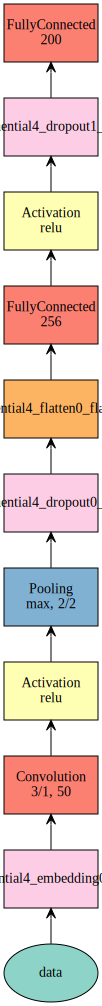

In [31]:
net.hybridize()
net.collect_params().initialize()
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)

# Initialize parameters, loss function, and training loop
Using "Xavier" to initialize parameter and 'rmsprop' for the optimizer. Everything else is pretty standard with softmax_cross_entropy as the loss function. Training loop goes through 5 epochs.  

In [32]:
# Intialize paramenters and determine loss function
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'rmsprop', {'learning_rate': 0.0005})

def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]
    
epochs = 5
smoothing_constant = .01
test_accuracy_list = []
for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
#         print("data shape is", data.shape)
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
#             print(output.shape)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        #  Keep a moving average of the losses
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    test_accuracy_list.append(test_accuracy)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))
#     if e == 0:
#         filename = os.path.join('/tmp/eider-user/userfile/'+username+'/', "testnet.params")
#         net.save_parameters(filename)
#         s3.Bucket('itk-model-data').upload_file(filename, 'testnet.params')
#     elif test_accuracy_list[e] > max(test_accuracy_list):
#         net.save_parameters(filename)
#         s3.Bucket('itk-model-data').upload_file(filename, 'testnet.params')
#     else:
#         pass


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:811: UserWarning: Parameter 'sequential4_embedding0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:811: UserWarning: Parameter 'sequential4_conv0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:811: UserWarning: Parameter 'sequential4_dense0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:811: UserWarning: Parameter 'sequential4_dense1_bias' is alrea

Epoch 0. Loss: 4.92246551154, Train_acc 0.0552458033573, Test_acc 0.0546762589928
Epoch 1. Loss: 4.01285473884, Train_acc 0.298021582734, Test_acc 0.279616306954
Epoch 2. Loss: 3.11311594413, Train_acc 0.475989208633, Test_acc 0.417386091127
Epoch 3. Loss: 2.4780531084, Train_acc 0.597511990408, Test_acc 0.488729016787
Epoch 4. Loss: 2.10568194173, Train_acc 0.644364508393, Test_acc 0.515707434053


In [34]:
# Get top K accuracy. Are the top K predicted values equal to the actual value?
def evaluate_topk_accuracy(data_iterator, net):
    acc = mx.metric.TopKAccuracy(top_k=10)
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        predictions = net(data)
        # predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

topk_accuracy = evaluate_topk_accuracy(test_data,net)
print("Top_K_acc %s" % (topk_accuracy))

Top_K_acc 0.726378896882


# Saving Model Artifacts

In [ ]:
# Save parameters
net.save_parameters("testnet.params")

s3 = boto3.client('s3')
s3.upload_file('testnet.params',bucket,'testnet.params')

In [39]:
# Use pickle to save all relevant training variables for use later
with open('vocab_labels.pickle', 'wb') as f:
    pickle.dump([vocabulary,vocab_size,sentence_size,labelencoder,unique_labels,test_accuracy_list], f)

s3.upload_file('vocab_labels.pickle',bucket,'vocab_labels.pickle')